## Dataset generation from deformable mirror

A Parabolic GRIN fiber or a Step-Index fiber can be used

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from mmfsim.grid import Grid
from mmfsim.fiber import GrinFiber, StepIndexFiber
from mmfsim.datasets import SimulatedGrinSpeckleOutputDataset, SimulatedStepIndexSpeckleOutputDataset, SimulatedSpeckleOutputDataset

### Setup

Set the computation grid and the fiber characteristics

In [2]:
fiber_type: str = 'step' # 'grin' or 'step'
grid_settings: dict = {'pixel_size': 0.5e-6, 'pixel_numbers': (256, 256)}
fiber_settings: dict = {'radius': 52.5e-6, 'wavelength': 1064e-9, 'n1': 1.465, 'n2': 1.44839}
dataset_settings: dict = {'length': 3000, 'degen': True, 'phases_dim': (12,12)}
fourier_settings: dict = {'pad': 1}
export_settings: dict = {'return_output_fields': True, 'add_exp_noise': True, 'noise_func': np.max, 'file_type': 'matlab'}

### Dataset generation

Generate the grid and the fiber

In [3]:
grid = Grid(**grid_settings)

if fiber_type.lower() in ['grin']:
    fiber = GrinFiber(**fiber_settings)
elif fiber_type.lower() in ['step', 'si']:
    fiber = StepIndexFiber(**fiber_settings)
else:
    raise ValueError(f"Unknown fiber type.")
print(fiber)

C:\Users\saucourt\Coding\MMF_LP_modes\mmfsim\fiber.py:246: RuntimeWarning: invalid value encountered in divide
  return sp.jv(n, u) / (u * sp.jv(n - 1, u)) + sp.kn(n, w) / (w * sp.kn(n - 1, w))
C:\Users\saucourt\Coding\MMF_LP_modes\mmfsim\fiber.py:245: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(v**2 - u**2)


StepIndexFiber instance with:
  - Radius: 52.5 um
  - Core index: 1.465
  - Cladding index: 1.44839
  - Wavelength: 1064.0 nm
  - Numerical aperture: 0.220
  - Number of guided LP modes: 595
  - Number of guided LP modes (counting degenerates): 1168
  - First 10 LP_n,m modes characteristics:
  n_eff      h          n          m
[[ 1.46498005  0.          0.          1.        ]
 [ 1.46494936  2.          1.          1.        ]
 [ 1.46490903  4.          2.          1.        ]
 [ 1.4648949   1.          0.          2.        ]
 [ 1.4648596   6.          3.          1.        ]
 [ 1.46483024  3.          1.          2.        ]
 [ 1.46480139  8.          4.          1.        ]
 [ 1.46475563  5.          2.          2.        ]
 [ 1.46474171  2.          0.          3.        ]
 [ 1.46473463 10.          5.          1.        ]]


Compute and store the modes for a much faster dataset generation, plot one for checking extent

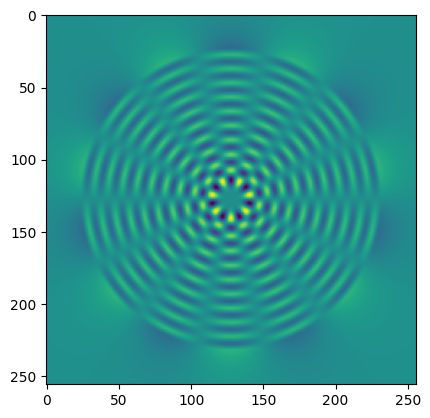

In [4]:
fiber.compute_modes_fields(grid)
plt.imshow(fiber._modes[:,:,1,-1])

Compute dataset

In [5]:
dset = SimulatedStepIndexSpeckleOutputDataset(fiber, grid, N_modes=fiber._N_modes_degen, length=dataset_settings['length'])
dset.compute_from_transfer_matrix(phases_dim=dataset_settings['phases_dim'])
dset.compute_fourier_transforms(**fourier_settings)

Found 20 input variable weights below threshold 0.001 to delete.
Successfully deleted low weight input variables.
Computed TM row 1/124
Computed TM row 2/124
Computed TM row 3/124
Computed TM row 4/124
Computed TM row 5/124
Computed TM row 6/124
Computed TM row 7/124
Computed TM row 8/124
Computed TM row 9/124
Computed TM row 10/124
Computed TM row 11/124
Computed TM row 12/124
Computed TM row 13/124
Computed TM row 14/124
Computed TM row 15/124
Computed TM row 16/124
Computed TM row 17/124
Computed TM row 18/124
Computed TM row 19/124
Computed TM row 20/124
Computed TM row 21/124
Computed TM row 22/124
Computed TM row 23/124
Computed TM row 24/124
Computed TM row 25/124
Computed TM row 26/124
Computed TM row 27/124
Computed TM row 28/124
Computed TM row 29/124
Computed TM row 30/124
Computed TM row 31/124
Computed TM row 32/124
Computed TM row 33/124
Computed TM row 34/124
Computed TM row 35/124
Computed TM row 36/124
Computed TM row 37/124
Computed TM row 38/124
Computed TM row 39/12

### Dataset checking and export

Display a random draw from the dataset as a check

Text(0.5, 1.0, 'Far field intensity')

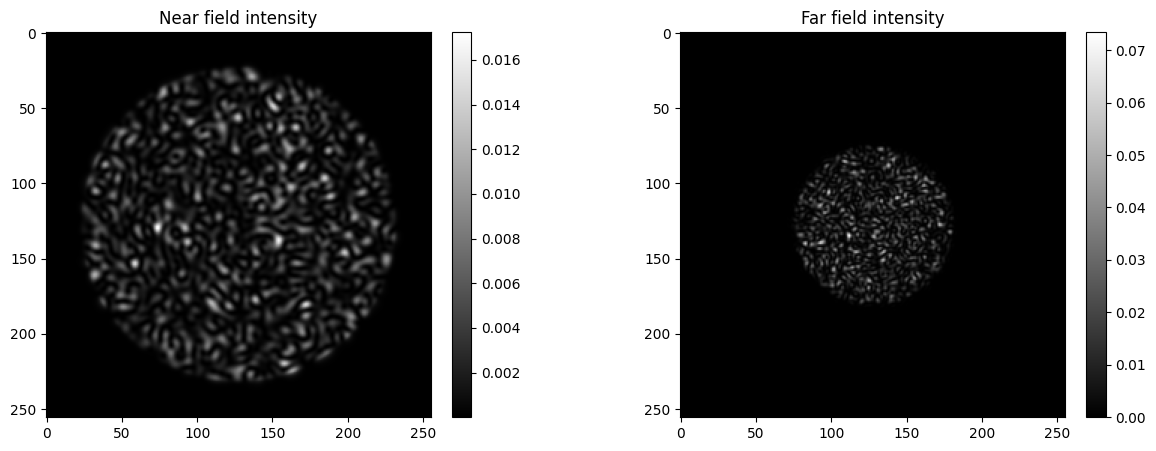

In [6]:
rand_idx = np.random.randint(0, dset._fields.shape[-1])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
nf = axs[0].imshow(dset.intensities[..., rand_idx], cmap='gray')
ff = axs[1].imshow(np.square(np.abs(dset._transf[..., rand_idx])), cmap='gray')
plt.colorbar(nf, ax=axs[0], fraction=0.046, pad=0.04)
plt.colorbar(ff, ax=axs[1], fraction=0.046, pad=0.04)
axs[0].set_title('Near field intensity')
axs[1].set_title('Far field intensity')

Export it if it looks ok

In [7]:
dset.export(**export_settings)

Dataset saved: .\synth_dset_step_lambda=1064nm_Nmodes=1168_degen=True_len=3000_mirr=144_exp_noise.mat
